<a href="https://colab.research.google.com/github/marcellinusc/production-oil-rate-prediction/blob/master/rnn_model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/marcellinusc/production-oil-rate-prediction/master/XM-18.csv \
    -O /tmp/XM-18.csv

--2020-06-19 03:06:00--  https://raw.githubusercontent.com/marcellinusc/production-oil-rate-prediction/master/XM-18.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142394 (139K) [text/plain]
Saving to: ‘/tmp/XM-18.csv’

/tmp/XM-18.csv      100%[===================>] 139.06K  --.-KB/s    in 0.02s   

2020-06-19 03:06:00 (7.64 MB/s) - ‘/tmp/XM-18.csv’ saved [142394/142394]



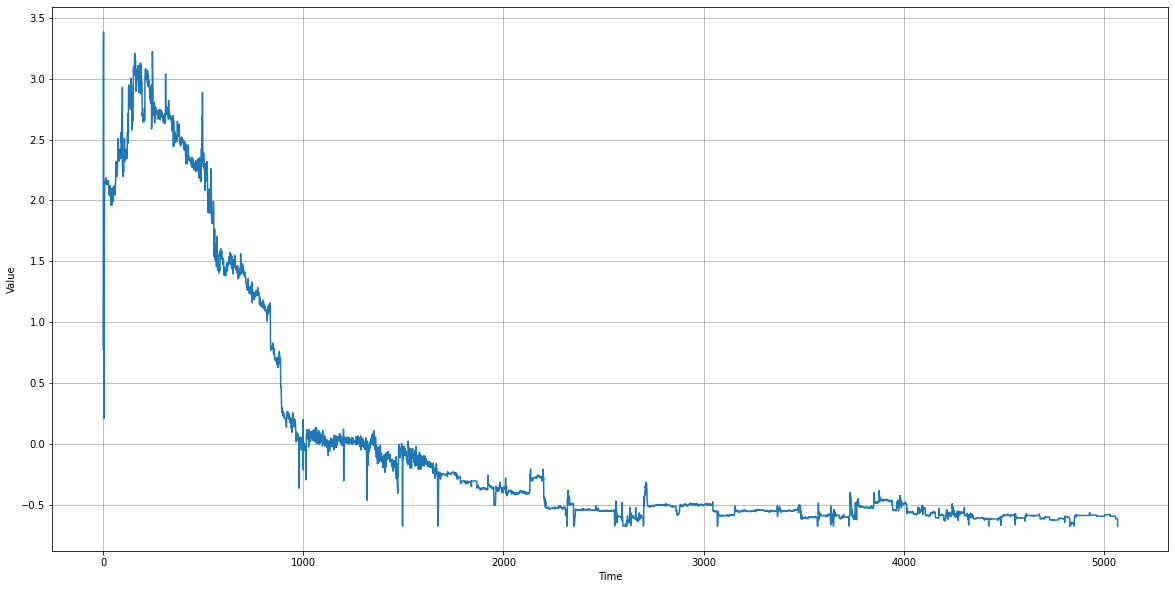

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/XM-18.csv') as csvfile:
  # YOUR CODE HERE
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[2]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(20, 10))
plot_series(time, series)

In [6]:
split_time = 4000
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4000,)
Epoch 1/100
16/16 [==============================] - 1s 58ms/step - loss: 2.0815 - mae: 2.5241 - lr: 1.0000e-08
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 1.8730 - mae: 2.3236 - lr: 1.1220e-08
Epoch 3/100
16/16 [==============================] - 1s 63ms/step - loss: 1.6429 - mae: 2.1011 - lr: 1.2589e-08
Epoch 4/100
16/16 [==============================] - 1s 60ms/step - loss: 1.4430 - mae: 1.9019 - lr: 1.4125e-08
Epoch 5/100
16/16 [==============================] - 1s 62ms/step - loss: 1.2741 - mae: 1.7328 - lr: 1.5849e-08
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 1.1273 - mae: 1.5858 - lr: 1.7783e-08
Epoch 7/100
16/16 [==============================] - 1s 61ms/step - loss: 1.0058 - mae: 1.4614 - lr: 1.9953e-08
Epoch 8/100
16/16 [==============================] - 1s 60ms/step - loss: 0.9188 - mae: 1.3638 - lr: 2.2387e-08
Ep

(1e-08, 0.0001, 0.0, 2.0)

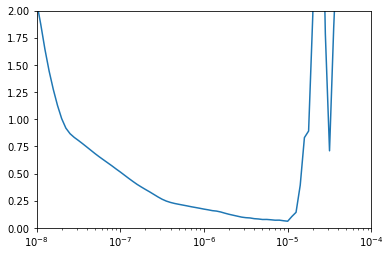

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 2])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9) # YOUR CODE HERE
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150) # YOUR CODE HERE

# EXPECTED OUTPUT 
# You should see an MAE of <2 within about 30 epochs

Epoch 1/150
40/40 [==============================] - 1s 34ms/step - loss: 1.7158 - mae: 2.1245
Epoch 2/150
40/40 [==============================] - 1s 34ms/step - loss: 0.2113 - mae: 0.4617
Epoch 3/150
40/40 [==============================] - 1s 32ms/step - loss: 0.0480 - mae: 0.1977
Epoch 4/150
40/40 [==============================] - 1s 33ms/step - loss: 0.0425 - mae: 0.1846
Epoch 5/150
40/40 [==============================] - 1s 32ms/step - loss: 0.0394 - mae: 0.1772
Epoch 6/150
40/40 [==============================] - 1s 33ms/step - loss: 0.0373 - mae: 0.1725
Epoch 7/150
40/40 [==============================] - 1s 32ms/step - loss: 0.0365 - mae: 0.1723
Epoch 8/150
40/40 [==============================] - 1s 33ms/step - loss: 0.0356 - mae: 0.1711
Epoch 9/150
40/40 [==============================] - 1s 32ms/step - loss: 0.0347 - mae: 0.1689
Epoch 10/150
40/40 [==============================] - 1s 33ms/step - loss: 0.0331 - mae: 0.1665
Epoch 11/150
40/40 [=============================

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

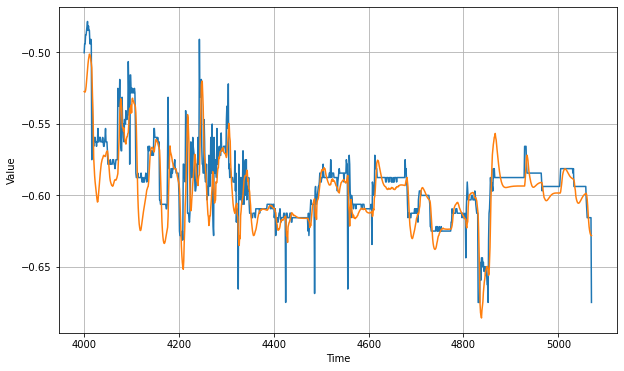

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT
# Plot should show projections following original data closely

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT 
# MAE < 2 -- Laurence got 1.789626

0.011179439

In [21]:
print(rnn_forecast)

# EXPECTED OUTPUT 
# Array of values in the low teens

[-0.52757496 -0.5278895  -0.52791    ... -0.62733966 -0.627966
 -0.62810564]
